# Exploring data normalization and analysis in large TMT experimental designs
## Part 4 - Statistical testing with similar samples

### Phil Wilmarth, OHSU PSR Core, February 2018
In Part 1, several normalization methods were used on a developing mouse lens TMT study that spanned three 6-plex TMT labeling experiments. It was clear that an IRS-like procedure is critical to combining data from multiple TMT experiments because the different TMT experiments act like different batches. We also saw that increases in expression of several highly abundant lens proteins during the time course created a compositional bias in the samples that could be corrected by procedures like TMM.

In Part 2, we compared two rather different conditions: early development (E15 plus E18) to later development (P6 plus P9) because we could have some reasonable expectation of the differences due to what is known about the lens. We looked at using ratios of samples to a standard as an alternative to scaling experiments based on the standard values in Part 3.

In this installment, we will look at comparing P0 to P3 with and without IRS normalization. These samples should be relatively similar, so we will use TMM normalization. We will stick with an exact test in edgeR so that we are not changing too many things at once.
> Robinson, M.D., McCarthy, D.J. and Smyth, G.K., 2010. edgeR: a Bioconductor package for differential expression analysis of digital gene expression data. Bioinformatics, 26(1), pp.139-140.

>Robinson, M.D. and Oshlack, A., 2010. A scaling normalization method for differential expression analysis of RNA-seq data. Genome biology, 11(3), p.R25.

Data from:
>Khan, S.Y., Ali, M., Kabir, F., Renuse, S., Na, C.H., Talbot, C.C., Hackett, S.F. and Riazuddin, S.A., 2018. Proteome Profiling of Developing Murine Lens Through Mass Spectrometry. Investigative ophthalmology & visual science, 59(1), pp.100-107.

<br>


## Let's start fresh and reload the data

In [53]:
# Analysis of IOVS mouse lens data (Supplemental Table S01):
# Khan, Shahid Y., et al. "Proteome Profiling of Developing Murine Lens Through Mass Spectrometry." 
# Investigative Ophthalmology & Visual Science 59.1 (2018): 100-107.

# load libraries
library(tidyverse) # modern R packages for big data analysis
library(limma) # edgeR will load this if we do not
library(edgeR)

# read the Supplemental 01 file (saved as a CSV export from XLSX file)
data_start <- read_csv("iovs-58-13-55_s01.csv")

# filter out proteins not seen in all three runs
data_no_na <- na.omit(data_start)

# fix the column headers
col_headers <- colnames(data_no_na)
col_headers <- str_replace(col_headers, " {2,3}", " ")
col_headers <- str_replace(col_headers, "Reporter ion intensities ", "")
colnames(data_no_na) <- col_headers

# save the annotation columns (gene symbol and protein accession) for later and remove from data frame
annotate_df <- data_no_na[1:2]
data_raw <- data_no_na[3:20]
row.names(data_raw) <- annotate_df$`Protein Accession No.`

Parsed with column specification:
cols(
  .default = col_double(),
  `Gene Symbol (NCBI)` = col_character(),
  `Protein Accession No.` = col_character()
)
See spec(...) for full column specifications.
Warning message:
“Setting row names on a tibble is deprecated.”

### We need to do SL and IRS normalizations

In [54]:
# separate the TMT data by experiment
exp1_raw <- data_raw[c(1:6)]
exp2_raw <- data_raw[c(7:12)]
exp3_raw <- data_raw[c(13:18)]

# figure out the global scaling value
target <- mean(c(colSums(exp1_raw), colSums(exp2_raw), colSums(exp3_raw)))

# do the sample loading normalization before the IRS normalization
# there is a different correction factor for each column
# seems like a loop could be used here somehow...
norm_facs <- target / colSums(exp1_raw)
exp1_sl <- sweep(exp1_raw, 2, norm_facs, FUN = "*")
norm_facs <- target / colSums(exp2_raw)
exp2_sl <- sweep(exp2_raw, 2, norm_facs, FUN = "*")
norm_facs <- target / colSums(exp3_raw)
exp3_sl <- sweep(exp3_raw, 2, norm_facs, FUN = "*")

# make a pre-IRS data frame after sample loading norms
data_sl <- cbind(exp1_sl, exp2_sl, exp3_sl)

# make working frame with row sums from each frame
irs <- tibble(rowSums(exp1_sl), rowSums(exp2_sl), rowSums(exp3_sl))
colnames(irs) <- c("sum1", "sum2", "sum3")

# get the geometric average intensity for each protein
irs$average <- apply(irs, 1, function(x) exp(mean(log(x))))

# compute the scaling factor vectors
irs$fac1 <- irs$average / irs$sum1
irs$fac2 <- irs$average / irs$sum2
irs$fac3 <- irs$average / irs$sum3

# make new data frame with normalized data
data_irs <- exp1_sl * irs$fac1
data_irs <- cbind(data_irs, exp2_sl * irs$fac2)
data_irs <- cbind(data_irs, exp3_sl * irs$fac3)

## Exact pair-wise testing in edgeR
### Setting up the experiment design and loading the data
We start with a data frame where the rows are the different protein expression levels and the columns are the biological samples. We need to get the data into an edgeR DGEList object. This data container holds the count data and the sample mapping information. We have to tell edgeR which samples belong to which groups. When we perform the statistical testing, we will have to specify which two groups are being compared. We will do an analysis of the SL data without IRS first. EdgeR will work better if we load all 18 samples in the DGEList object and estimate dispersions on the full dataset. We will limit the pair-wise comparison to the P0 versus P3 samples below.


Design matrix not provided. Switch to the classic mode.


,group,lib.size,norm.factors
E15_Set1,E15,9826475337,1.7553031
E18_Set1,E18,9826475337,1.4989245
P0_Set1,P0,9826475337,1.3713938
P3_Set1,P3,9826475337,1.1606568
P6_Set1,P6,9826475337,0.9922070
P9_Set1,P9,9826475337,0.8278740
E15_Set2,E15,9826475337,1.5307406
E18_Set2,E18,9826475337,1.3668135
P0_Set2,P0,9826475337,1.1875263
P3_Set2,P3,9826475337,0.8306536


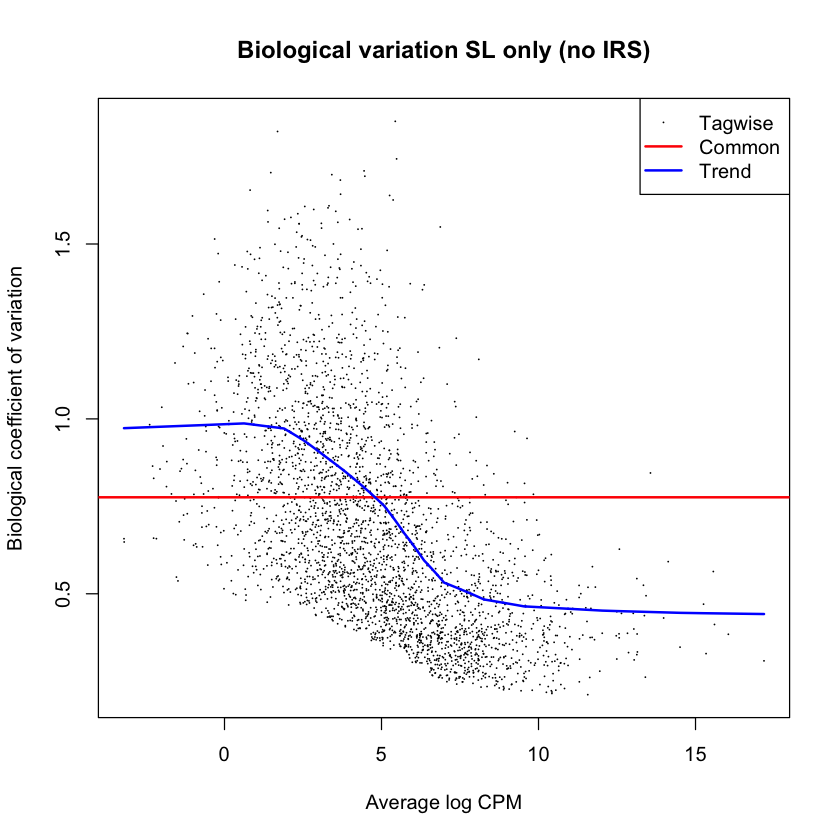

In [55]:
# set up the sample mapping
group <- rep(c("E15", "E18", "P0", "P3", "P6", "P9"), 3)

# make group into factors and set the order
group <- factor(group, levels = c("E15", "E18", "P0", "P3", "P6", "P9"))

# create a DGEList object with our data
y_sl <- DGEList(counts = data_sl, group = group)

# we need to run TMM norm and estimate the dispersion
y_sl <- calcNormFactors(y_sl)
y_sl <- estimateDisp(y_sl)
y_sl$samples
plotBCV(y_sl, main = "Biological variation SL only (no IRS)")

# we need to transform the SL data with TMM factors for later plotting
sl_tmm <- calcNormFactors(data_sl)
data_sl_tmm <- sweep(data_sl, 2, sl_tmm, FUN = "/") # this is data after SL and TMM on original scale

## Do the Exact test between early and late and see how many candidates (FDR < 0.05)
We have loaded the data, performed TMM normalizations, and estimated dispersion factors for the statistical modeling. Now we will perform a modified Fisher's exact test between the P0 and P3 groups.

In [56]:
# the exact test object has columns like fold-change, CPM, and p-values
et_sl <- exactTest(y_sl, pair = c("P0", "P3"))
summary(decideTestsDGE(et_sl)) # this counts up, down, and unchanged genes (here it is proteins)

       P0+P3
Down       0
NotSig  3155
Up         0

## The high variance without doing IRS eliminates all DE candidates
We might expect that P0 and P3 are not too different, but there should be some changes in expression.

In [57]:
# the topTags function adds the BH FDR values to an exactTest data frame. Make sure we do not change the row order!
tt_sl <- topTags(et_sl, n = Inf, sort.by = "none")
tt_sl <- tt_sl$table # tt_sl is a list. We just need the data frame table

# add the default value as a new column
tt_sl$candidate <- "no"
tt_sl[which(tt_sl$FDR <= 0.10 & tt_sl$FDR > 0.05), dim(tt_sl)[2]] <- "low"
tt_sl[which(tt_sl$FDR <= 0.05 & tt_sl$FDR > 0.01), dim(tt_sl)[2]] <- "med"
tt_sl[which(tt_sl$FDR <= 0.01), dim(tt_sl)[2]] <- "high"
tt_sl$candidate <- factor(tt_sl$candidate, levels = c("high", "med", "low", "no"))

# what does tt_sl look like?
head(tt_sl)

logFC,logCPM,PValue,FDR,candidate
0.7688977,17.18071,0.03600705,0.9999957,no
0.5134693,15.60409,0.29499317,0.9999957,no
0.3971478,16.04543,0.38389285,0.9999957,no
0.7573050,15.33568,0.05304246,0.9999957,no
2.6182098,13.56508,0.01603679,0.9999957,no
0.6582113,14.13001,0.35423876,0.9999957,no


## Is the statistical test behaving correctly?
Non-differentially-expressed proteins should produce a uniformly distributed (flat) background of p-values (at all values from 0.0 to 1.0). Any true differential candidates will be a second distribution peaked at very small p-values. This is a good example of what the p-value distribution should not look like! The variances are so large compared to the means, that the distribution is skewed.

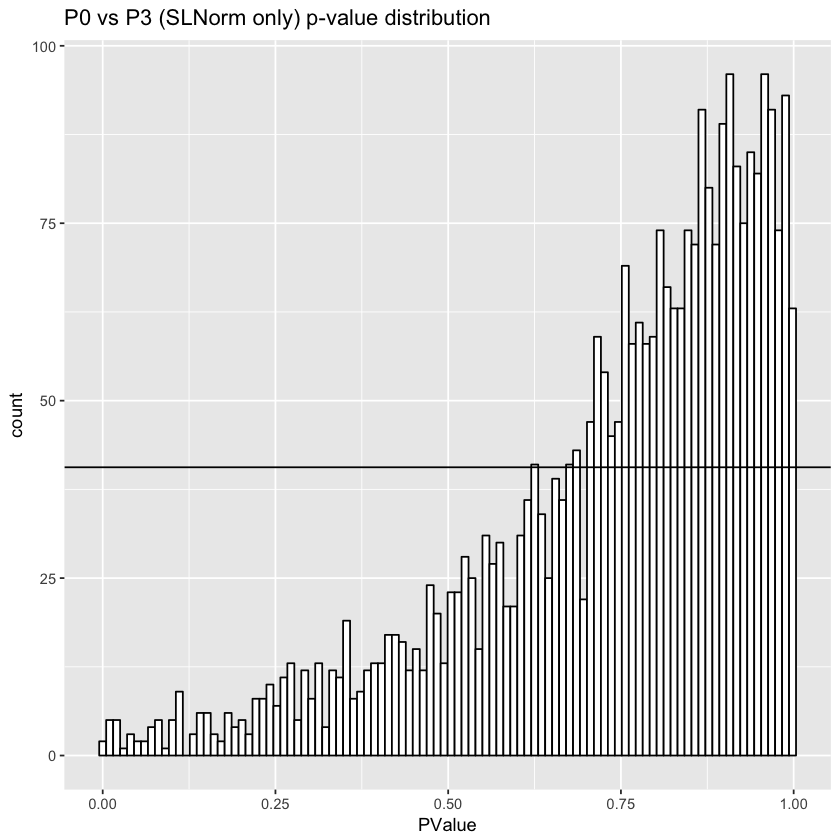

In [58]:
# what does the test p-value distribution look like?
ggplot(tt_sl, aes(PValue)) + 
  geom_histogram(bins = 100, fill = "white", color = "black") + 
  geom_hline(yintercept = mean(hist(tt_sl$PValue, breaks = 100, plot = FALSE)$counts[26:100])) +
  ggtitle("P0 vs P3 (SLNorm only) p-value distribution")

In [59]:
# for plotting results, we will use the average intensities for the 3 P0 and the 3 P3 samples
P0 <- c(3, 9, 15)
P3 <- c(4, 10, 16)
de_sl <- data.frame(rowMeans(data_sl_tmm[P0]), rowMeans(data_sl_tmm[P3]), tt_sl$candidate)
colnames(de_sl) <- c("P0", "P3", "candidate")
volcano_sl <- data.frame(log2(rowMeans(data_sl[P0])/rowMeans(data_sl[P3])), log10(tt_sl$FDR)*(-1), tt_sl$candidate)
colnames(volcano_sl) <- c("FoldChange", "FDR", "candidate")

## Make plots and color code by candidate status
We will do three types of plots for visualizing the DE candidates: mean-difference plots (common in genomics), scatter plots (my favorite), and a volcano plot. For the MA plots and scatter plots, we will also separate the plots by candidate status.

The solid diagonal lines are the unity line and the dotted lies are plus/minus 2-fold. Since we have no candidates, the non-candidates are orange points, and the separate plots are the same.

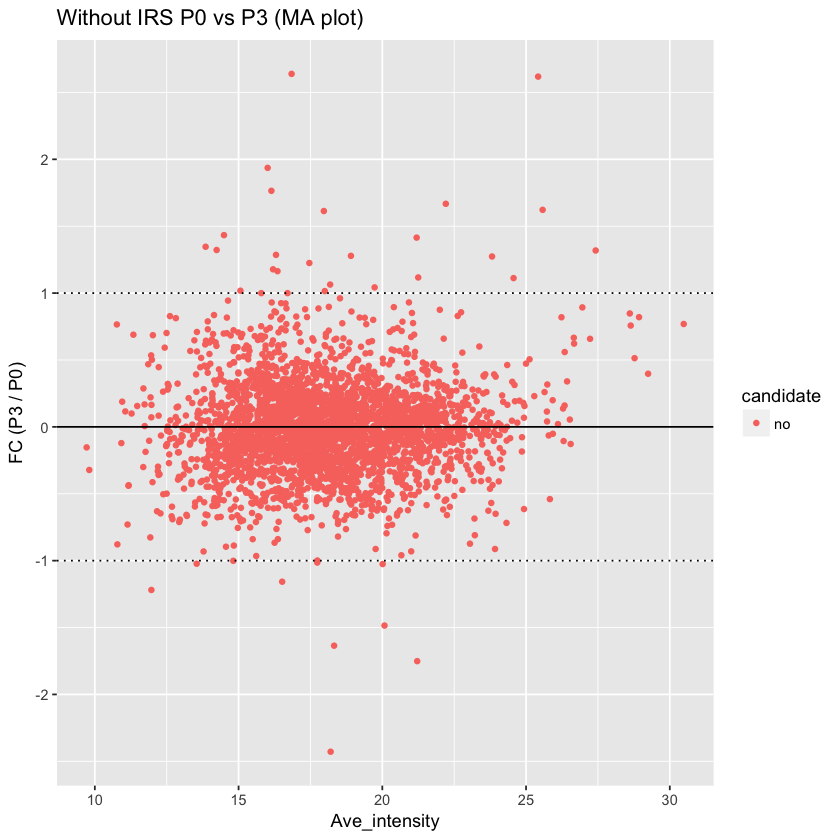

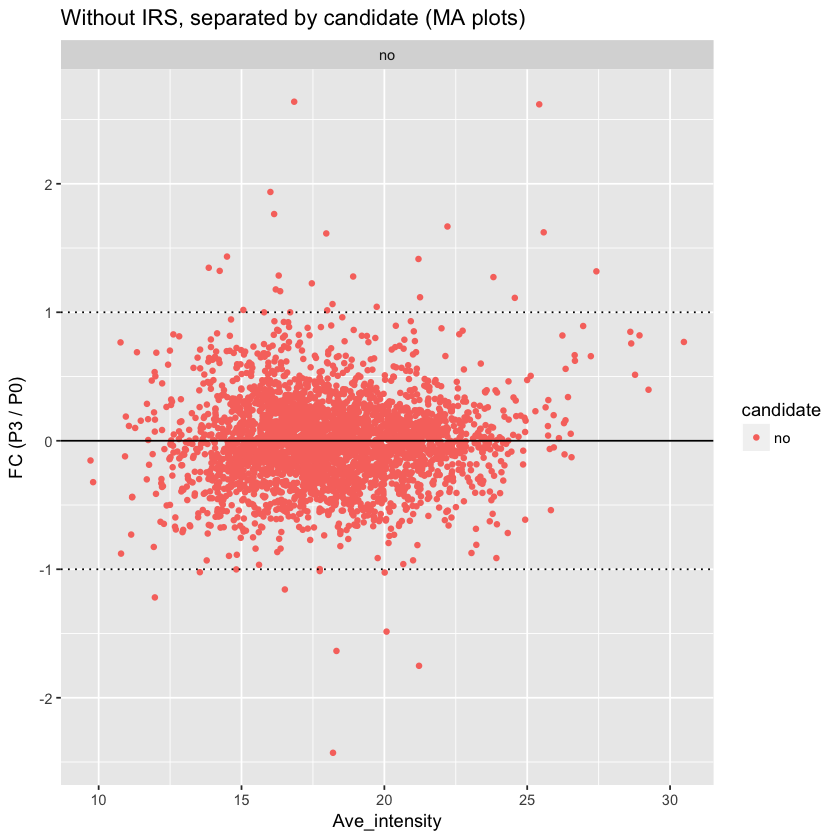

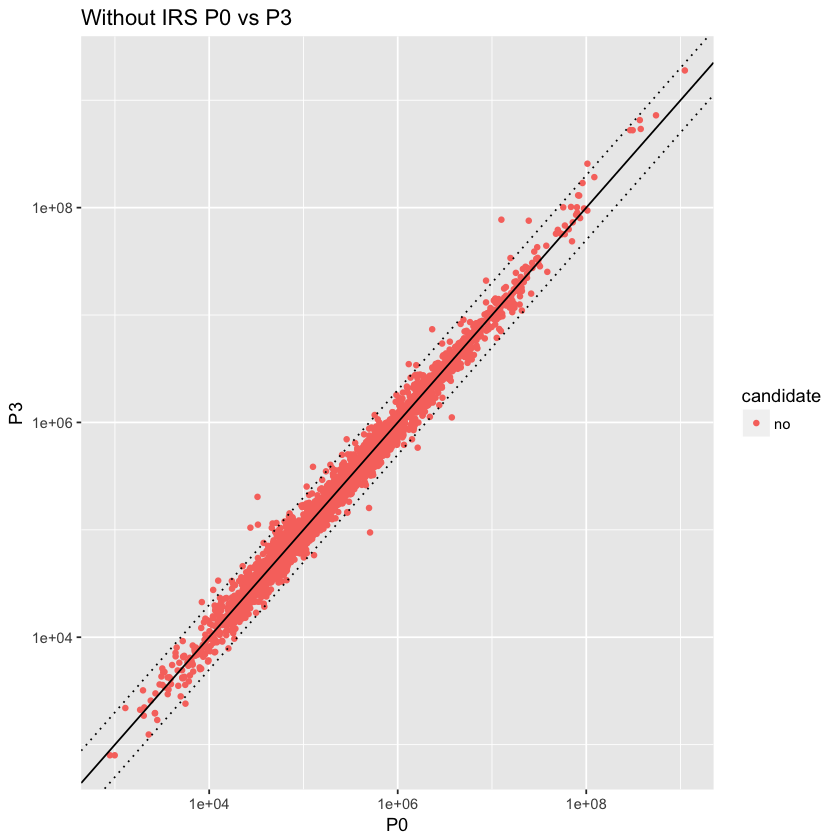

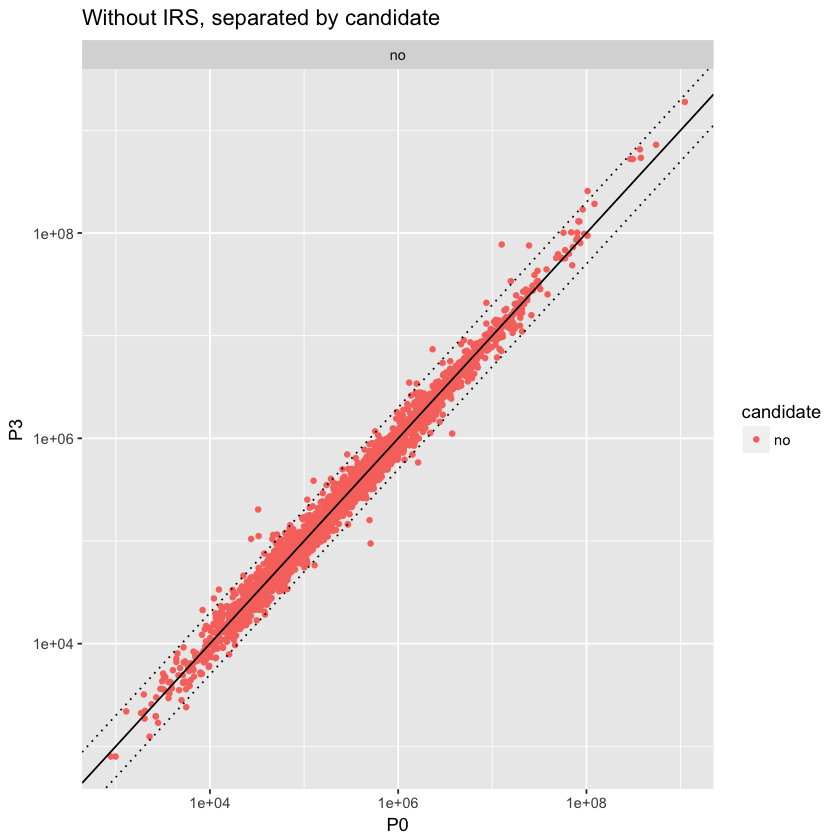

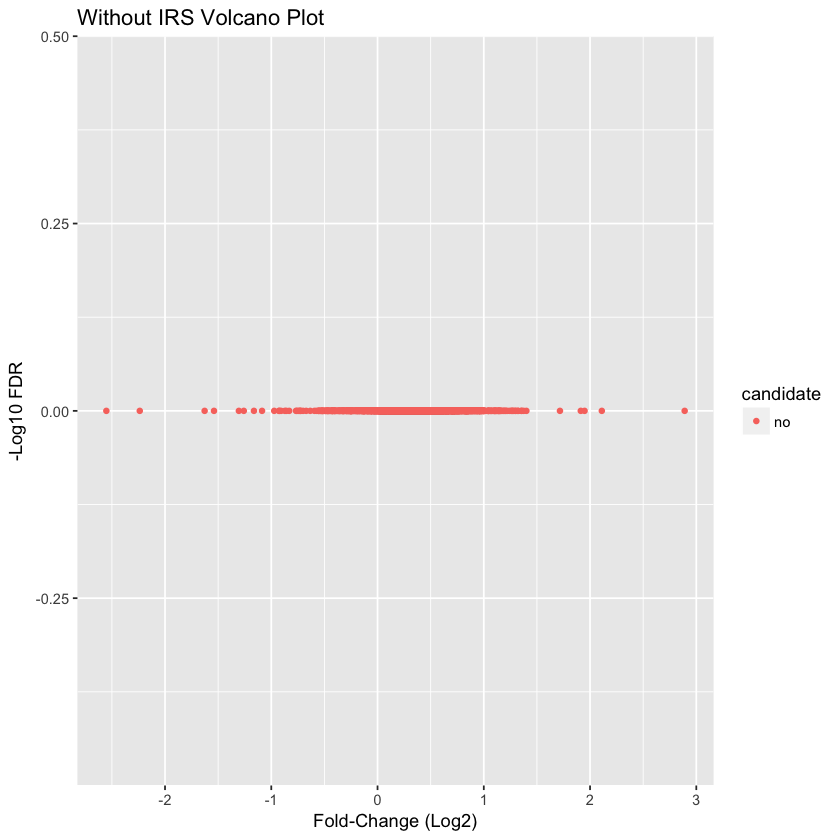

In [60]:
# start with MA plot
library(scales)
temp <- data.frame(log2((de_sl$P0 + de_sl$P3)/2), log2(de_sl$P3/de_sl$P0), de_sl$candidate)
colnames(temp) <- c("Ave", "FC", "candidate")
ggplot(temp, aes(x = Ave, y = FC)) +
  geom_point(aes(color = candidate, shape = candidate)) +
  scale_y_continuous("FC (P3 / P0)") +
  scale_x_continuous("Ave_intensity") +
  ggtitle("Without IRS P0 vs P3 (MA plot)") + 
  geom_hline(yintercept = 0.0, color = "black") + # one-to-one line
  geom_hline(yintercept = 1.0, color = "black", linetype = "dotted") + # 2-fold up
  geom_hline(yintercept = -1.0, color = "black", linetype = "dotted") # 2-fold down

# make separate MA plots
ggplot(temp, aes(x = Ave, y = FC)) +
  geom_point(aes(color = candidate, shape = candidate)) +
  scale_y_continuous("FC (P3 / P0)") +
  scale_x_continuous("Ave_intensity") +
  geom_hline(yintercept = 0.0, color = "black") + # one-to-one line
  geom_hline(yintercept = 1.0, color = "black", linetype = "dotted") + # 2-fold up
  geom_hline(yintercept = -1.0, color = "black", linetype = "dotted") + # 2-fold down
  facet_wrap(~ candidate) +
  ggtitle("Without IRS, separated by candidate (MA plots)")

# make the combined candidate corelation plot
ggplot(de_sl, aes(x = P0, y = P3)) +
  geom_point(aes(color = candidate, shape = candidate)) +
  scale_y_log10() +
  scale_x_log10() +
  ggtitle("Without IRS P0 vs P3") + 
  geom_abline(intercept = 0.0, slope = 1.0, color = "black") + # one-to-one line
  geom_abline(intercept = 0.301, slope = 1.0, color = "black", linetype = "dotted") + # 2-fold up
  geom_abline(intercept = -0.301, slope = 1.0, color = "black", linetype = "dotted") # 2-fold down

# make separate corelation plots
ggplot(de_sl, aes(x = P0, y = P3)) +
  geom_point(aes(color = candidate, shape = candidate)) +
  scale_y_log10() +
  scale_x_log10() +
  geom_abline(intercept = 0.0, slope = 1.0, color = "black") + # one-to-one line
  geom_abline(intercept = 0.301, slope = 1.0, color = "black", linetype = "dotted") + # 2-fold up
  geom_abline(intercept = -0.301, slope = 1.0, color = "black", linetype = "dotted") + # 2-fold down
  facet_wrap(~ candidate) +
  ggtitle("Without IRS, separated by candidate")

# make a volcano plot
ggplot(volcano_sl, aes(x = FoldChange, y = FDR)) +
  geom_point(aes(color = candidate, shape = candidate)) +
  xlab("Fold-Change (Log2)") +
  ylab("-Log10 FDR") +
  ggtitle("Without IRS Volcano Plot")

## Now let's see what effect IRS has
### Same steps, using the IRS data instead of the SL data

Design matrix not provided. Switch to the classic mode.


,group,lib.size,norm.factors
E15_Set1,E15,9270664774,1.5114732
E18_Set1,E18,9363761294,1.2419268
P0_Set1,P0,9451622436,1.1403959
P3_Set1,P3,9531837394,0.9451601
P6_Set1,P6,9537837657,0.8136767
P9_Set1,P9,9566996326,0.6791176
E15_Set2,E15,9253060468,1.5830751
E18_Set2,E18,9135830721,1.4090527
P0_Set2,P0,9597066116,1.1219356
P3_Set2,P3,9528757306,0.7748380


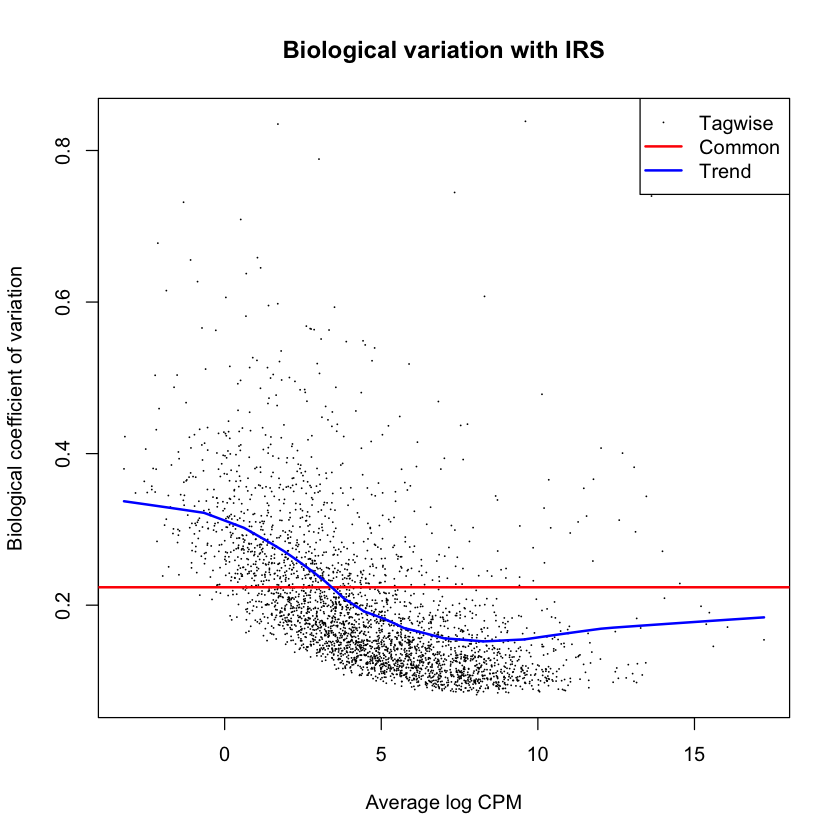

In [61]:
# create a DGEList object with the IRS data
y_irs <- DGEList(counts = data_irs, group = group)

# we need to normalize and estimate the dispersion terms (global and local)
y_irs <- calcNormFactors(y_irs)
y_irs <- estimateDisp(y_irs)
y_irs$samples
plotBCV(y_irs, main = "Biological variation with IRS")

# we need to transform the IRS data with TMM factors for later plotting
irs_tmm <- calcNormFactors(data_sl)
data_irs_tmm <- sweep(data_irs, 2, irs_tmm, FUN = "/") # this is data after SL and TMM on original scale

## Biological variation is greatly reduced after IRS and we have some DE candidates
### P-value distribution now looks more typical

In [62]:
# the exact test object has columns like fold-change, CPM, and p-values
et_irs <- exactTest(y_irs, pair = c("P0", "P3"))
summary(decideTestsDGE(et_irs)) # this counts up, down, and unchanged genes

       P0+P3
Down      38
NotSig  3066
Up        51

logFC,logCPM,PValue,FDR,candidate
0.7871157,17.21966,1.700120e-05,0.003575919,high
0.5603518,15.60201,1.140208e-03,0.044355404,med
0.4211099,16.05431,3.718613e-02,0.260743098,no
0.8195890,15.37622,7.927053e-05,0.009262908,high
2.7169591,13.62826,4.201875e-03,0.093608202,low
0.7694345,14.04192,1.945807e-03,0.059029043,low


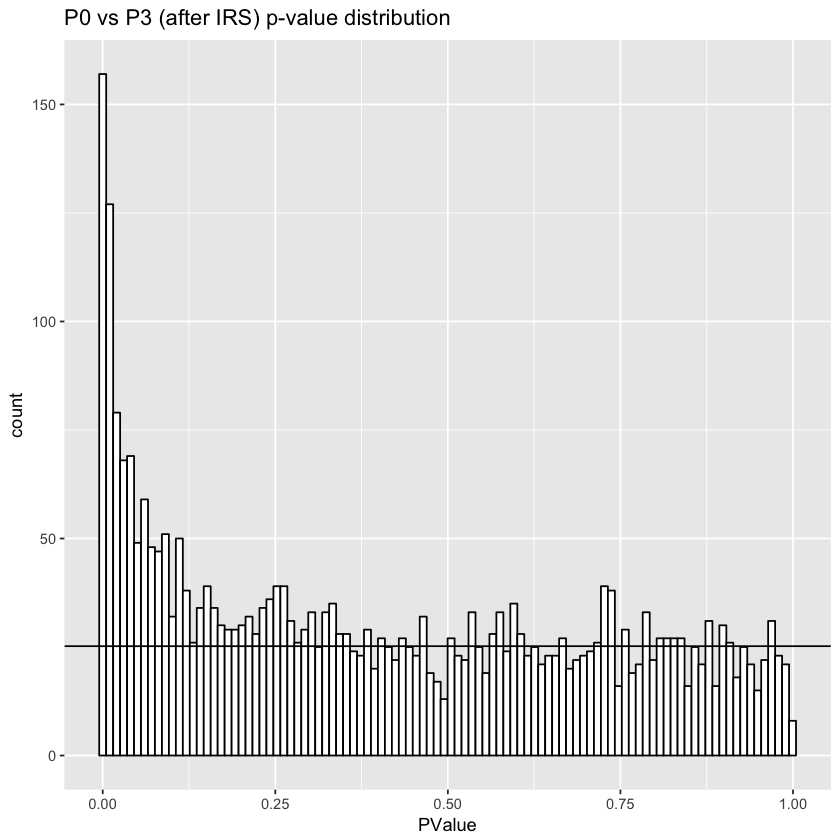

In [63]:
# the topTags function adds the BH FDR values to an exactTest data frame. Make sure we do not change the row order!
tt_irs <- topTags(et_irs, n = Inf, sort.by = "none")
tt_irs <- tt_irs$table # tt_sl is a list. We just need the data frame table

# add the default value as a new column
tt_irs$candidate <- "no"
tt_irs[which(tt_irs$FDR <= 0.10 & tt_irs$FDR > 0.05), dim(tt_irs)[2]] <- "low"
tt_irs[which(tt_irs$FDR <= 0.05 & tt_irs$FDR > 0.01), dim(tt_irs)[2]] <- "med"
tt_irs[which(tt_irs$FDR <= 0.01), dim(tt_irs)[2]] <- "high"
tt_irs$candidate <- factor(tt_irs$candidate, levels = c("high", "med", "low", "no"))

# what does tt_sl look like?
head(tt_irs)

# what does the test p-value distribution look like?
ggplot(tt_irs, aes(PValue)) + 
  geom_histogram(bins = 100, fill = "white", color = "black") + 
  geom_hline(yintercept = mean(hist(tt_irs$PValue, breaks = 100, plot = FALSE)$counts[26:100])) +
  ggtitle("P0 vs P3 (after IRS) p-value distribution")

## DE candidate plots after IRS
The solid lines are the unity line and the dotted lies are plus/minus 2-fold. Proteins with FDR values less than 0.01 are "high" significance candidates (orange), proteins with FDR between 0.05 and 0.01 are "medium" (sea green), proteins with FDR between 0.10 and 0.05 are "low" (teal), and proteins with FDR greater than 0.10 are non-candidates ("no", in purple).

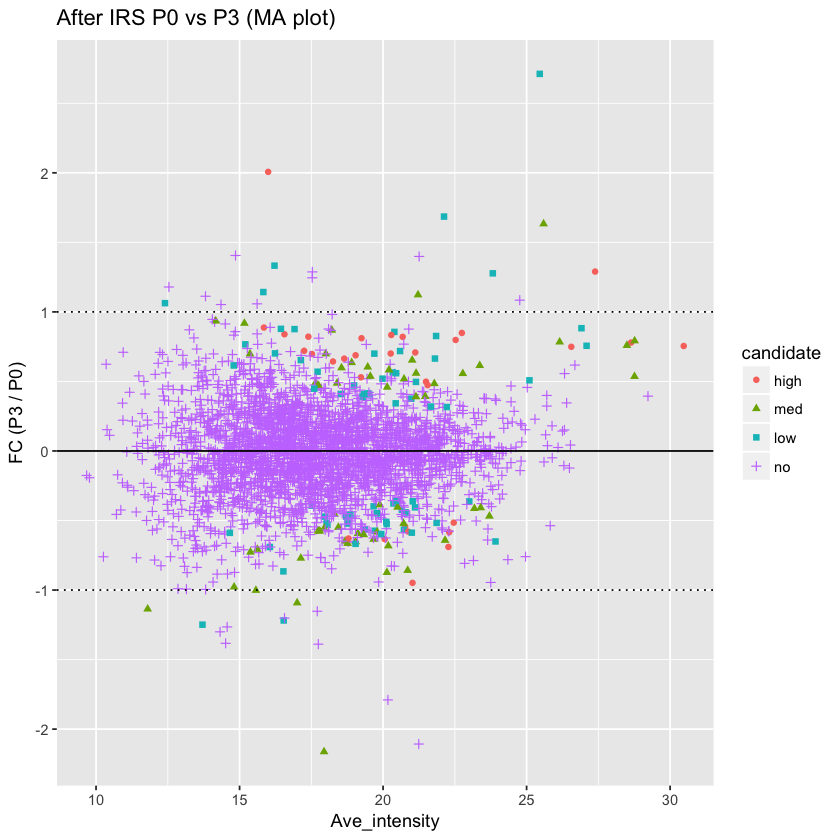

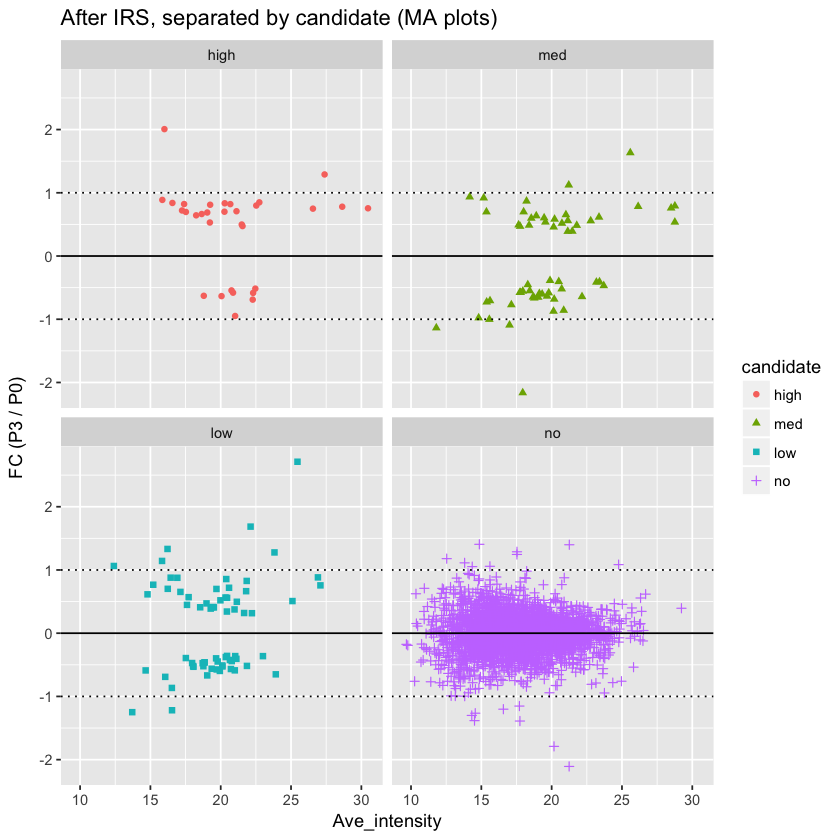

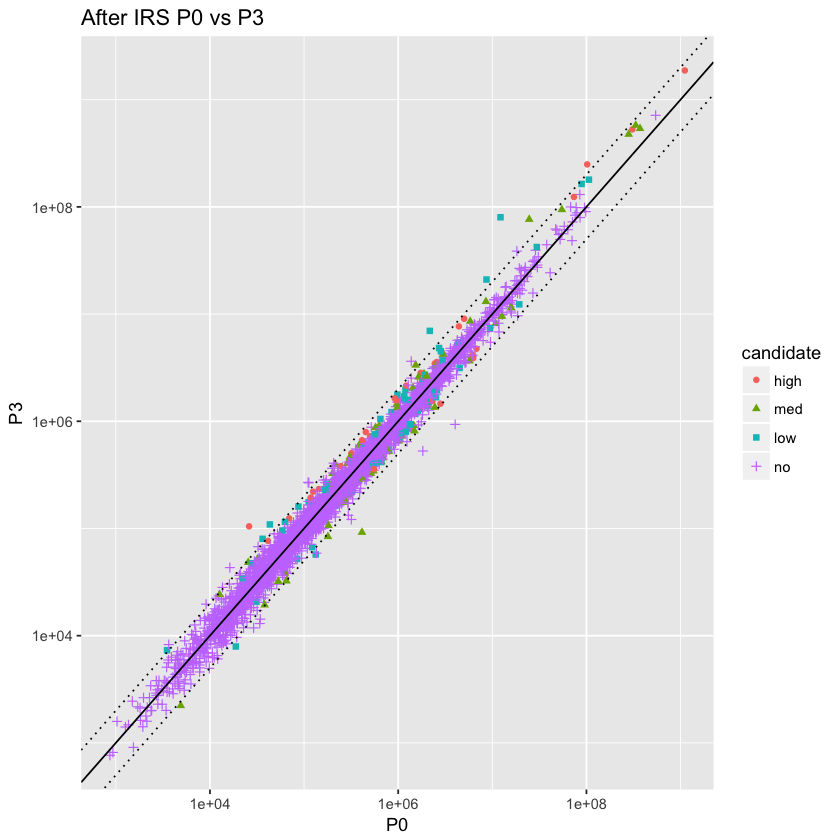

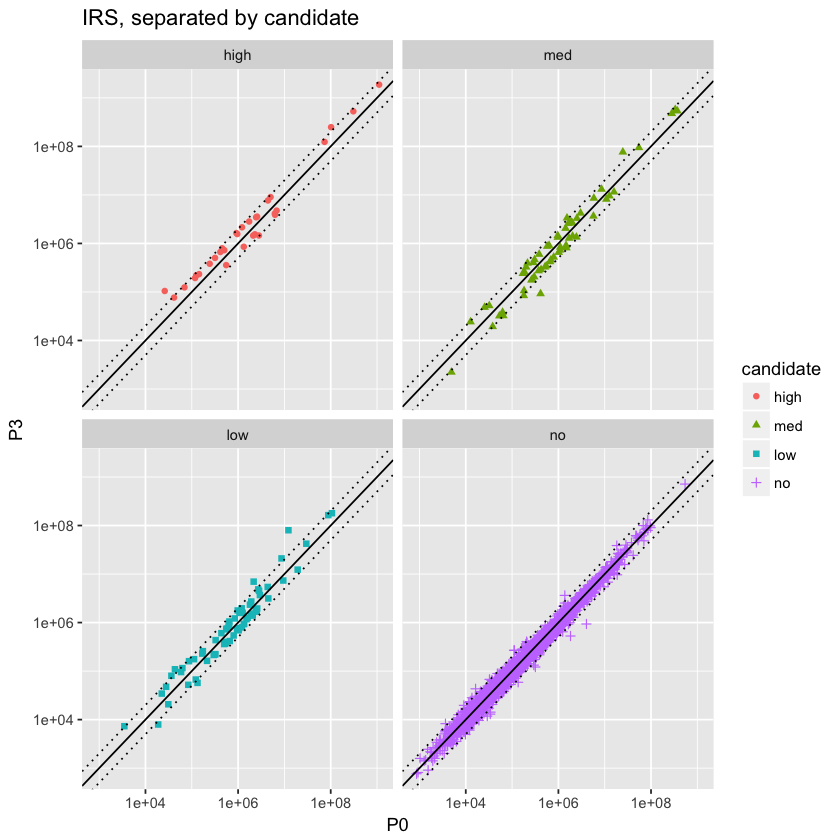

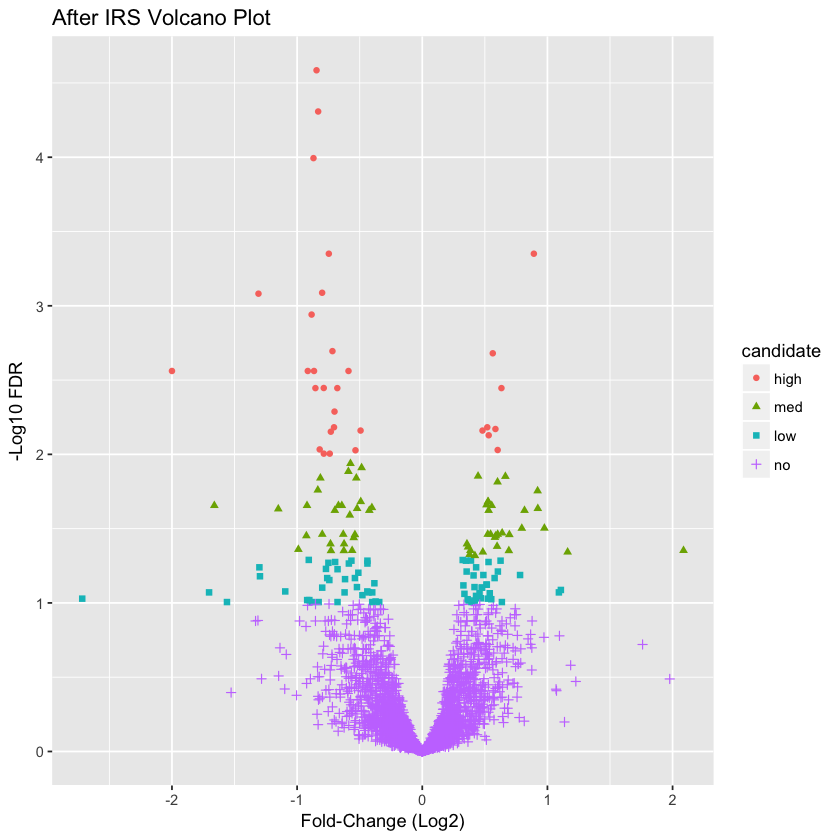

In [64]:
# for plotting results, we will use the average intensities for the P0 and the P3 samples
de_irs <- data.frame(rowMeans(data_irs_tmm[P0]), rowMeans(data_irs_tmm[P3]), tt_irs$candidate)
colnames(de_irs) <- c("P0", "P3", "candidate")
volcano_irs <- data.frame(-1*tt_irs$logFC, -1*log10(tt_irs$FDR), tt_irs$candidate)
colnames(volcano_irs) <- c("FoldChange", "FDR", "candidate")

# start with MA plot
temp <- data.frame(log2((de_irs$P0 + de_irs$P3)/2), log2(de_irs$P3/de_irs$P0), de_irs$candidate)
colnames(temp) <- c("Ave", "FC", "candidate")
ggplot(temp, aes(x = Ave, y = FC)) +
  geom_point(aes(color = candidate, shape = candidate)) +
  scale_y_continuous("FC (P3 / P0)") +
  scale_x_continuous("Ave_intensity") +
  ggtitle("After IRS P0 vs P3 (MA plot)") + 
  geom_hline(yintercept = 0.0, color = "black") + # one-to-one line
  geom_hline(yintercept = 1.0, color = "black", linetype = "dotted") + # 2-fold up
  geom_hline(yintercept = -1.0, color = "black", linetype = "dotted") # 2-fold down

# make separate MA plots
ggplot(temp, aes(x = Ave, y = FC)) +
  geom_point(aes(color = candidate, shape = candidate)) +
  scale_y_continuous("FC (P3 / P0)") +
  scale_x_continuous("Ave_intensity") +
  geom_hline(yintercept = 0.0, color = "black") + # one-to-one line
  geom_hline(yintercept = 1.0, color = "black", linetype = "dotted") + # 2-fold up
  geom_hline(yintercept = -1.0, color = "black", linetype = "dotted") + # 2-fold down
  facet_wrap(~ candidate) +
  ggtitle("After IRS, separated by candidate (MA plots)")

# make the combined candidate corelation plot
ggplot(de_irs, aes(x = P0, y = P3)) +
  geom_point(aes(color = candidate, shape = candidate)) +
  scale_y_log10() +
  scale_x_log10() +
  ggtitle("After IRS P0 vs P3") + 
  geom_abline(intercept = 0.0, slope = 1.0, color = "black") + # one-to-one line
  geom_abline(intercept = 0.301, slope = 1.0, color = "black", linetype = "dotted") + # 2-fold up
  geom_abline(intercept = -0.301, slope = 1.0, color = "black", linetype = "dotted") # 2-fold down

# make separate corelation plots
ggplot(de_irs, aes(x = P0, y = P3)) +
  geom_point(aes(color = candidate, shape = candidate)) +
  scale_y_log10() +
  scale_x_log10() +
  geom_abline(intercept = 0.0, slope = 1.0, color = "black") + # one-to-one line
  geom_abline(intercept = 0.301, slope = 1.0, color = "black", linetype = "dotted") + # 2-fold up
  geom_abline(intercept = -0.301, slope = 1.0, color = "black", linetype = "dotted") + # 2-fold down
  facet_wrap(~ candidate) +
  ggtitle("IRS, separated by candidate")

# make a volcano plot
ggplot(volcano_irs, aes(x = FoldChange, y = FDR)) +
  geom_point(aes(color = candidate, shape = candidate)) +
  xlab("Fold-Change (Log2)") +
  ylab("-Log10 FDR") +
  ggtitle("After IRS Volcano Plot")

## The statistical testing after IRS seems more reasonable
## Let's look at the scatter plots of the sample averages for P0 and P3, before and after IRS 
We will not highlight candidates and we will add marginal histograms.

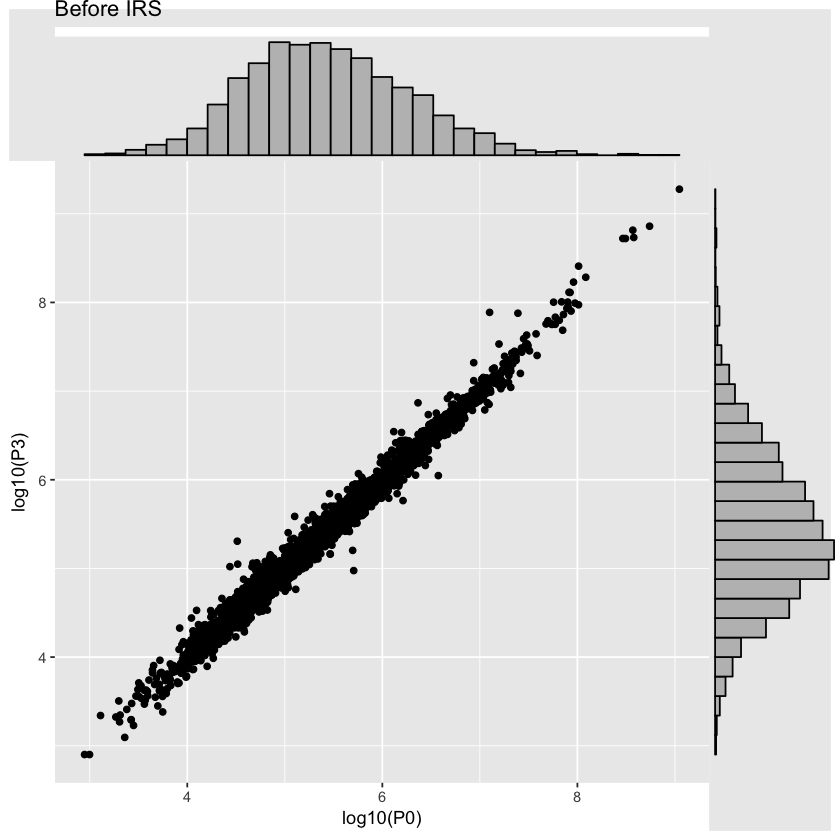

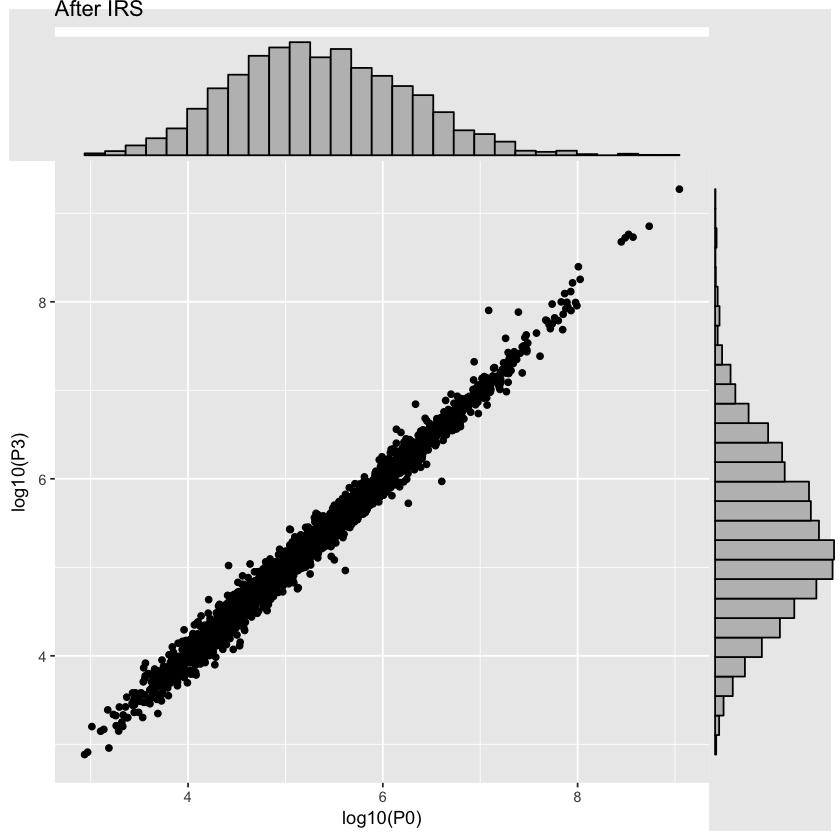

In [65]:
library(ggExtra)
# add marginal distrubution histograms to basic correlation plot (good starting point)
ggplot()
corr_plot <- ggplot(de_sl, aes(x = log10(P0), y = log10(P3))) +
  geom_point() + ggtitle("Before IRS")
ggMarginal(corr_plot, type = "histogram")

ggplot()
corr_plot <- ggplot(de_irs, aes(x = log10(P0), y = log10(P3))) +
  geom_point() + ggtitle("After IRS")
ggMarginal(corr_plot, type = "histogram")

## Average intensities are not very informative about underlying variance
As we saw in Part 2, the average values across TMT experiments do not depend too much on whether the IRS method is done or not. The variance, a key component in the statistical testing, is dramatically different with and without IRS.

## Random sampling of MS2 scans between LC runs negates the precision of TMT labeling
Reference standards are truly needed in TMT experiments. Either IRS normalization or ratios to a common reference are required to remove the random sampling effect.